In [1]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import networkx as nx
import GraphTransforms as Tr
import torch_geometric.transforms as T
import GraphNN as G
import GraphDataSets as D
import random

from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, auc
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from mpl_toolkits.axes_grid1 import make_axes_locatable

/lhome/ific/l/lopezneu/ific108/software/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dataset_name = 'RecoBig_all_10mm_R2'
transform    = True
DS = getattr(D,dataset_name)
if transform:
    dataset = DS(root='./GNN_datasets/',transform=Tr.RandomNodeSplit())#, pre_transform=transform)
    dataset_name += '_T'
else:
    dataset   = DS(root='GNN_datasets/')

%mkdir 'IN_{dataset_name}'
graph_dataset = dataset[:int(2/3*len(dataset))]
test_dataset  = dataset[int(2/3*len(dataset)):]

mkdir: cannot create directory 'IN_RecoBig_all_10mm_R2_T': File exists


In [3]:
path  = dataset_name+'_best.pth'
model = G.InteractionNetwork(128, dataset=dataset, inputs = dataset.num_node_features, outputs = 2)
model.load_state_dict(torch.load(path,map_location='cpu'))
model.eval()

InteractionNetwork(
  (interactionnetwork): MetaLayer(
    edge_model=EdgeBlock(
    (edge_mlp): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
  ),
    node_model=NodeBlock(
    (node_mlp_1): Sequential(
      (0): Linear(in_features=132, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
    (node_mlp_2): Sequential(
      (0): Linear(in_features=132, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
  ),
    global_model=GlobalBlock(
    (global_mlp): Sequential(
     

In [4]:
valid_frac = 0.20
full_length = len(graph_dataset)
valid_num = int(valid_frac*full_length)
batch_size = 32

train_dataset, valid_dataset = random_split(graph_dataset, [full_length-valid_num,valid_num])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [5]:
def IN_analysis(loader):
    t = tqdm(enumerate(loader),total=len(loader))
    y_test = []
    y_predict = []
    for i,data in t: 
        try:
            batch_output = model(data.x, data.edge_index, data.edge_attr, data.u, data.batch)
        except:
            batch_output = model(data.x, data.edge_index, data.edge_attr, None, data.batch)
        for j,obj in enumerate(batch_output.detach().cpu().numpy()):
            y_predict.append(batch_output.detach().cpu().numpy()[j][1])
        y_test.append(data.y.cpu().numpy())
    y_test = np.concatenate(y_test)
    y_predict = np.array(y_predict)
    y_predict = np.exp(y_predict)/(1+np.exp(y_predict))
        
    #calculate scores
    B_score = []
    S_score = []
    t = tqdm(range(0, len(y_predict)))

    for i in t:
        if y_test[i]==0:
            B_score.append(y_predict[i])
        else:
            S_score.append(y_predict[i])
            
    # create ROC curves and FOM
    fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test, y_predict)
    Seff = []
    Brej = []
    Figm = []
    thre = np.linspace(min(y_predict),max(y_predict),100)
    t    = tqdm(range(0,len(thre)))

    for i in t:
        Seff.append(len([x for x in S_score if x>=thre[i]])/len(S_score))
        Brej.append(1-len([x for x in B_score if x>=thre[i]])/len(B_score))
        Figm.append(len([x for x in S_score if x>=thre[i]])*np.sqrt(len(B_score))/
                (np.sqrt(len([x for x in B_score if x>=thre[i]]))*len(S_score)))
        

    return y_test, y_predict, fpr_gnn, tpr_gnn, threshold_gnn, Seff, Brej, Figm, thre, B_score, S_score

In [6]:
y_test, y_predict, fpr_gnn_tr, tpr_gnn_tr, threshold_gnn_tr, Seff_tr, Brej_tr, Figm_tr, thre_tr, B_score_tr, S_score_tr = IN_analysis(train_loader)
y_test, y_predict, fpr_gnn_vl, tpr_gnn_vl, threshold_gnn_vl, Seff_vl, Brej_vl, Figm_vl, thre_vl, B_score_vl, S_score_vl = IN_analysis(valid_loader)
y_test, y_predict, fpr_gnn_te, tpr_gnn_te, threshold_gnn_te, Seff_te, Brej_te, Figm_te, thre_te, B_score_te, S_score_te = IN_analysis( test_loader)


  0%|          | 0/5055 [00:00<?, ?it/s]

  0%|          | 0/161760 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/fkellere/ipykernel_131898/2144226746.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  Figm.append(len([x for x in S_score if x>=thre[i]])*np.sqrt(len(B_score))/


  0%|          | 0/1264 [00:00<?, ?it/s]

  0%|          | 0/40439 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/fkellere/ipykernel_131898/2144226746.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  Figm.append(len([x for x in S_score if x>=thre[i]])*np.sqrt(len(B_score))/


  0%|          | 0/3160 [00:00<?, ?it/s]

  0%|          | 0/101100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/fkellere/ipykernel_131898/2144226746.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  Figm.append(len([x for x in S_score if x>=thre[i]])*np.sqrt(len(B_score))/


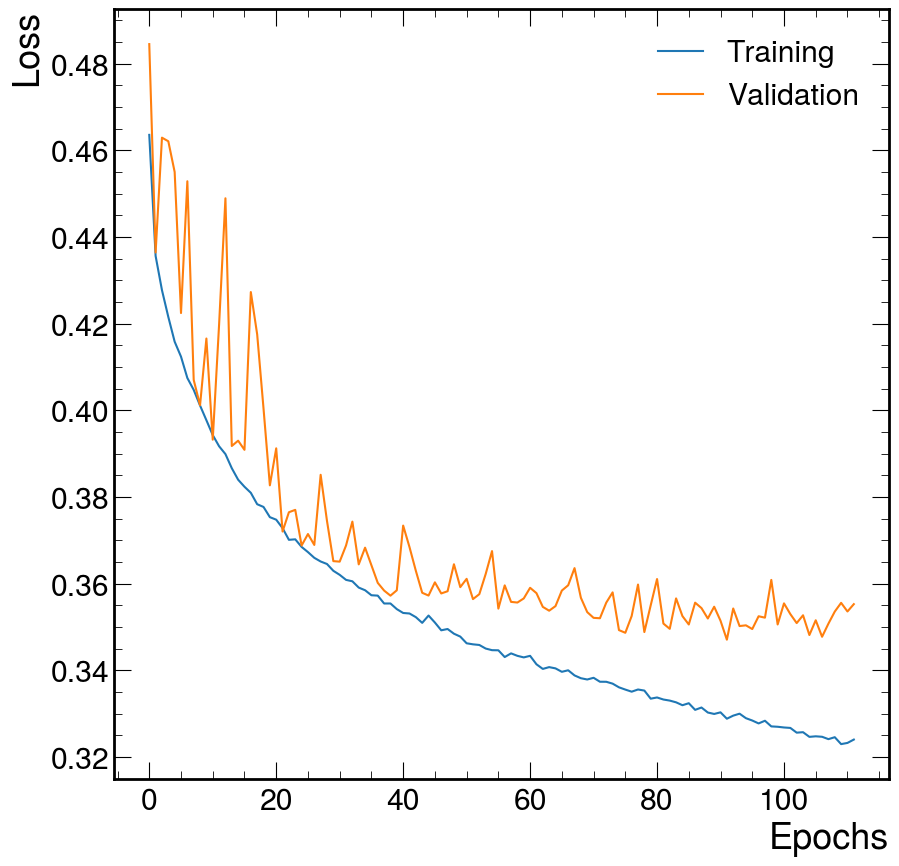

In [7]:
plt.style.use(hep.style.ROOT)

store = pd.HDFStore("Loss_"+dataset_name+".h5")
plt.plot(store['loss_tr'],label='Training')
plt.plot(store['loss_te'],label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0,1])
plt.legend()
plt.savefig(f'IN_{dataset_name}/Loss.png',bbox_inches='tight')

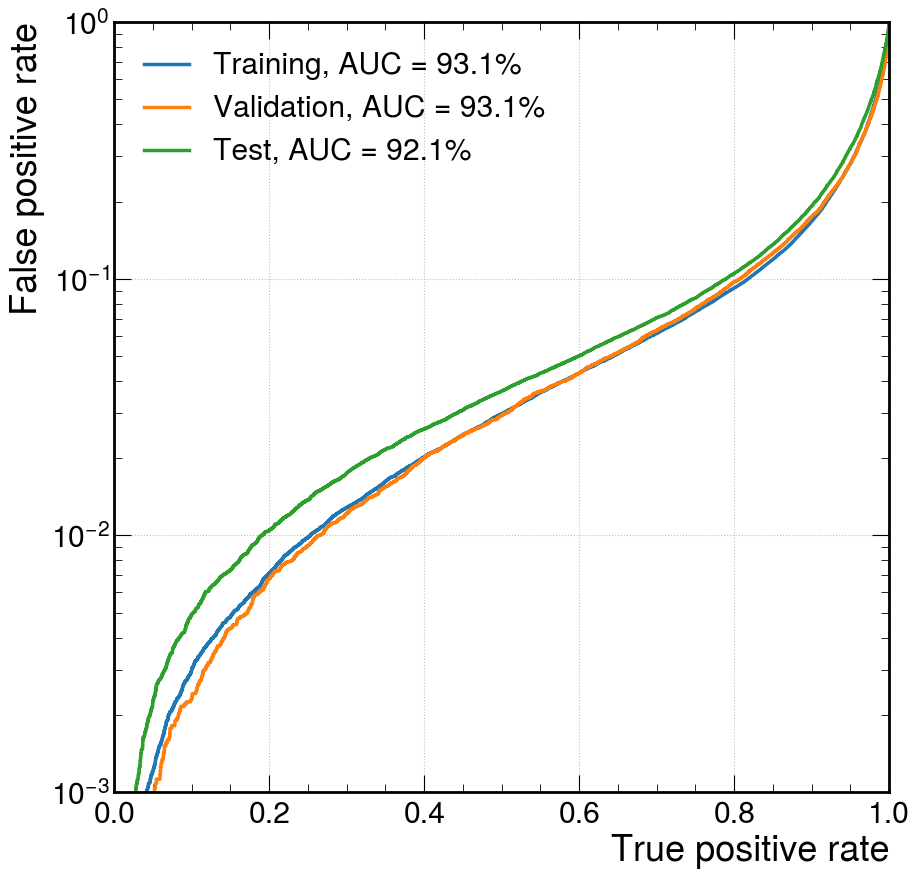

In [8]:
plt.style.use(hep.style.ROOT)
    
# plot ROC curves
plt.figure()
plt.plot(tpr_gnn_tr, fpr_gnn_tr, lw=2.5, label="Training, AUC = {:.1f}%".format(auc(fpr_gnn_tr,tpr_gnn_tr)*100))
plt.plot(tpr_gnn_vl, fpr_gnn_vl, lw=2.5, label="Validation, AUC = {:.1f}%".format(auc(fpr_gnn_vl,tpr_gnn_vl)*100))
plt.plot(tpr_gnn_te, fpr_gnn_te, lw=2.5, label="Test, AUC = {:.1f}%".format(auc(fpr_gnn_te,tpr_gnn_te)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.savefig(f'IN_{dataset_name}/ROC.png',bbox_inches='tight')
plt.show()

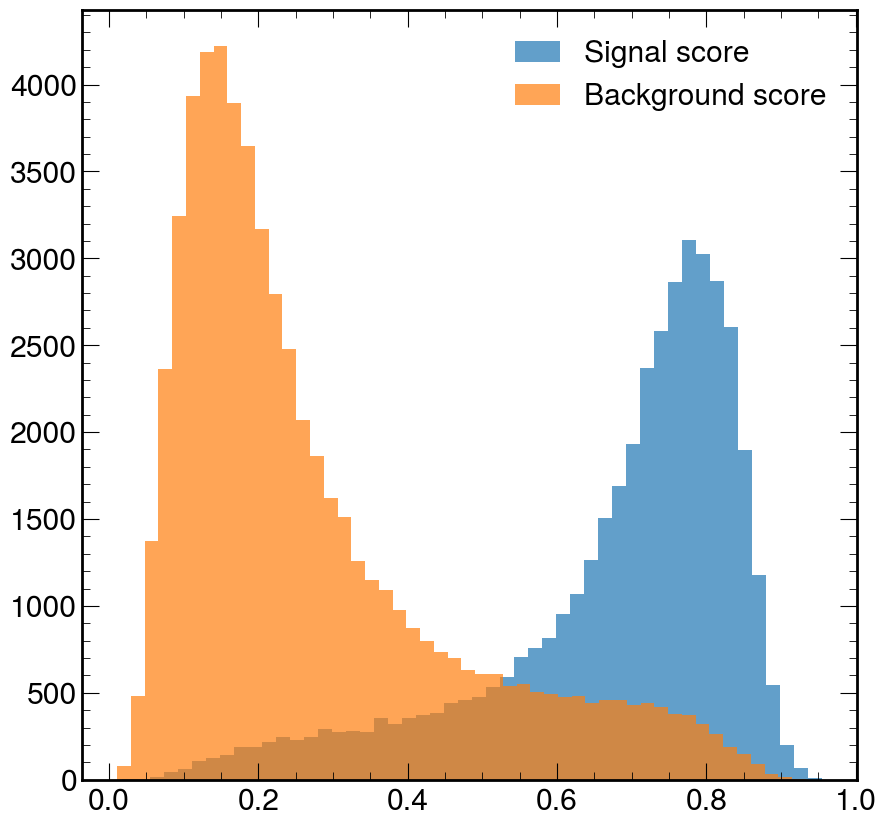

In [9]:
plt.style.use(hep.style.ROOT)

plt.hist(S_score_te, 50, label='Signal score', alpha=0.7)
plt.hist(B_score_te, 50, label='Background score', alpha=0.7)
#plt.semilogy()
plt.legend()
plt.savefig(f'IN_{dataset_name}/Scoring.png',bbox_inches='tight')

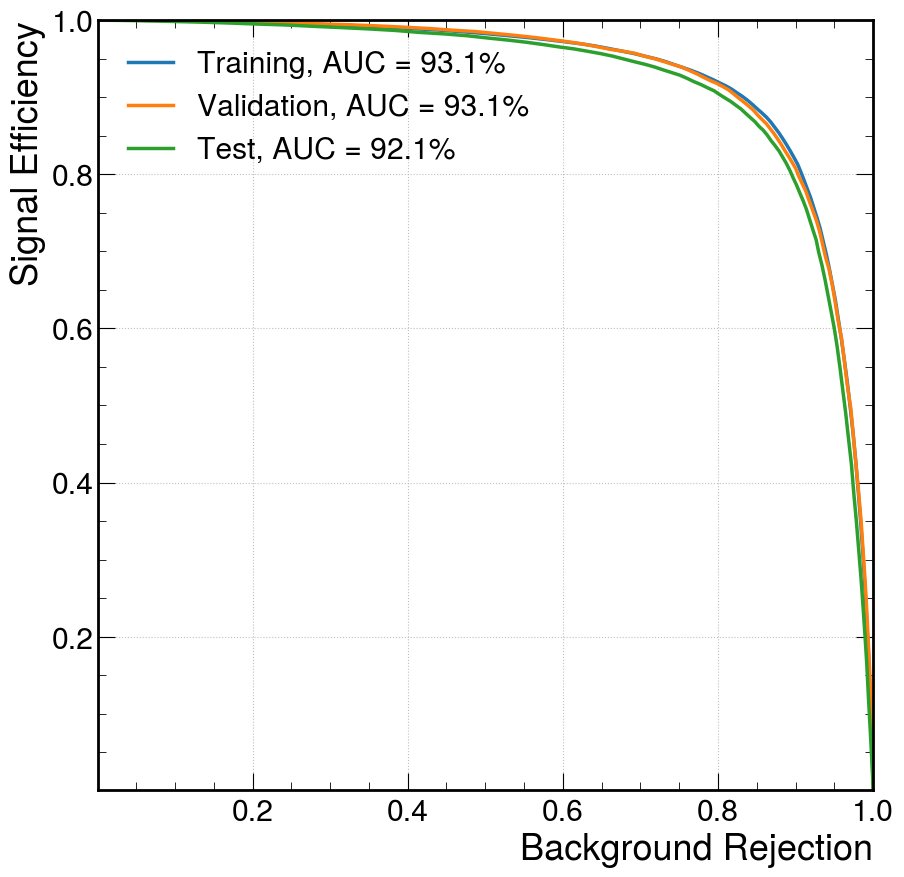

In [10]:
plt.style.use(hep.style.ROOT)

plt.figure()
plt.plot(Brej_tr, Seff_tr, lw=2.5, label="Training, AUC = {:.1f}%".format(auc(Brej_tr,Seff_tr)*100))
plt.plot(Brej_vl, Seff_vl, lw=2.5, label="Validation, AUC = {:.1f}%".format(auc(Brej_vl,Seff_vl)*100))
plt.plot(Brej_te, Seff_te, lw=2.5, label="Test, AUC = {:.1f}%".format(auc(Brej_te,Seff_te)*100))
plt.xlabel(r'Background Rejection')
plt.ylabel(r'Signal Efficiency')
plt.ylim(0.001, 1)
plt.xlim(0.001, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.savefig(f'IN_{dataset_name}/ROC2.png',bbox_inches='tight')
plt.show()

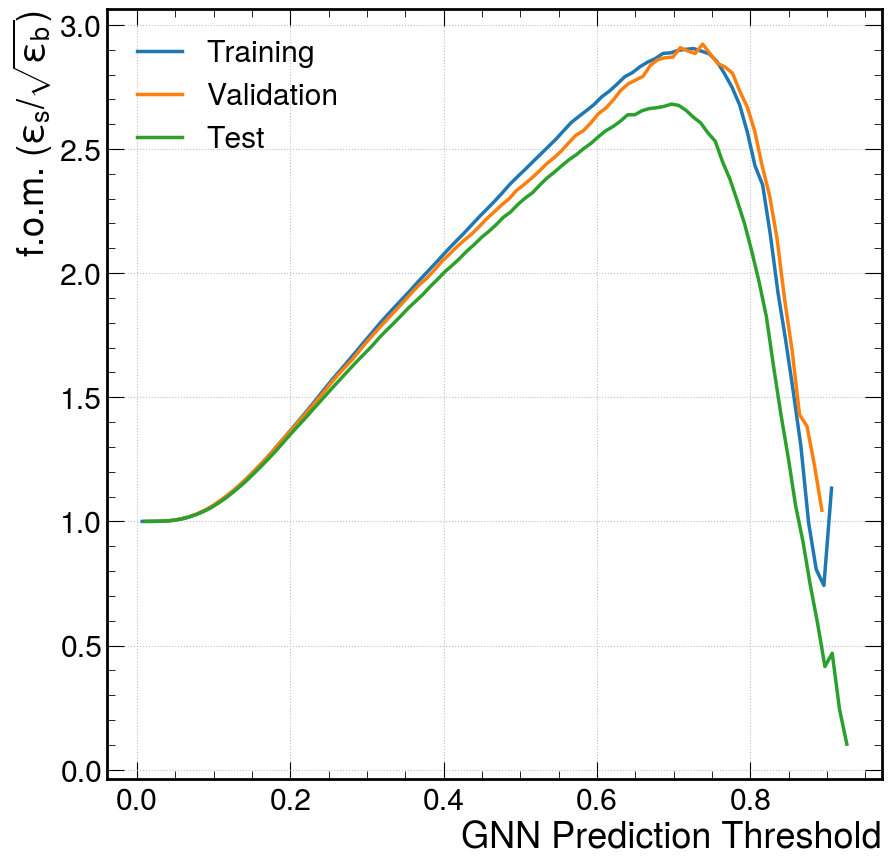

In [11]:
plt.style.use(hep.style.ROOT)

plt.figure()
plt.plot(thre_tr, Figm_tr, lw=2.5, label = "Training")
plt.plot(thre_vl, Figm_vl, lw=2.5, label = "Validation")
plt.plot(thre_te, Figm_te, lw=2.5, label = "Test")
plt.xlabel(r'GNN Prediction Threshold')
plt.ylabel(r'f.o.m. ($\epsilon_{s}/\sqrt{\epsilon_{b}}$)')
plt.grid(True)
plt.legend()
plt.savefig(f'IN_{dataset_name}/FOM.png',bbox_inches='tight')
plt.show()

In [12]:
fom  = [x for x in Figm_te if x!=np.inf]
xmax = thre_te[np.argmax(fom)]

In [13]:
X = []
Y = []
Z = []
t = tqdm(range(0, len(test_dataset)))
for i in t:
    X.append(np.mean(test_dataset[i].u.numpy().transpose()[0]))
    Y.append(np.mean(test_dataset[i].u.numpy().transpose()[1]))
    Z.append(np.mean(test_dataset[i].u.numpy().transpose()[2]))

  0%|          | 0/101100 [00:00<?, ?it/s]

In [14]:
X_sorted, keys_x = zip(*sorted(zip(X,range(0,len(X)))))
Y_sorted, keys_y = zip(*sorted(zip(Y,range(0,len(Y)))))
Z_sorted, keys_z = zip(*sorted(zip(Z,range(0,len(Z)))))

In [15]:
nBins = 6
Xbins = np.linspace(min(X),max(X),nBins+1)
Ybins = np.linspace(min(Y),max(Y),nBins+1)
Zbins = np.linspace(min(Z),max(Z),nBins+1)
XYauc = []
XZauc = []
YZauc = []
XYRS  = []
XZRS  = []
YZRS  = []
XYRB  = []
XZRB  = []
YZRB  = []
s     = tqdm(range(0,nBins))

for i in s:
    keys_xi = keys_x[len([x for x in X if x<=Xbins[i]]):len([x for x in X if x<=Xbins[i+1]])]
    keys_yi = keys_y[len([x for x in Y if x<=Ybins[i]]):len([x for x in Y if x<=Ybins[i+1]])]
    keys_zi = keys_z[len([x for x in Z if x<=Zbins[i]]):len([x for x in Z if x<=Zbins[i+1]])]
    for j in tqdm(range(0,nBins)):
        keys_xj = keys_x[len([x for x in X if x<=Xbins[j]]):len([x for x in X if x<=Xbins[j+1]])]
        keys_yj = keys_y[len([x for x in Y if x<=Ybins[j]]):len([x for x in Y if x<=Ybins[j+1]])]
        keys_zj = keys_z[len([x for x in Z if x<=Zbins[j]]):len([x for x in Z if x<=Zbins[j+1]])]
        keys_xy = list(set(keys_xi).intersection(keys_yj))
        keys_xz = list(set(keys_xi).intersection(keys_zj))
        keys_yz = list(set(keys_yi).intersection(keys_zj))
        a       = np.array([y_test[x] for x in keys_xy])
        b       = np.array([y_predict[x] for x in keys_xy])
        PredS   = np.array([a[i] for i in range(0,len(a)) if b[i]>=xmax])
        PredB   = np.array([a[i] for i in range(0,len(a)) if b[i]<xmax])
        try:
            XYRS.append(len(PredS[PredS==1])/len(a[a==1]))
        except ZeroDivisionError:
            XYRS.append(0)
        try:
            XYRB.append(len(PredB[PredB==0])/len(a[a==0]))
        except ZeroDivisionError:
            XYRB.append(0)
        fpr, tpr, threshold = roc_curve(a,b)
        XYauc.append(auc(fpr,tpr))
        a    = np.array([y_test[x] for x in keys_xz])
        b    = np.array([y_predict[x] for x in keys_xz])
        PredS= np.array([a[i] for i in range(0,len(a)) if b[i]>=xmax])
        PredB= np.array([a[i] for i in range(0,len(a)) if b[i]<xmax])
        try:
            XZRS.append(len(PredS[PredS==1])/len(a[a==1]))
        except ZeroDivisionError:
            XZRS.append(0)
        try:
            XZRB.append(len(PredB[PredB==0])/len(a[a==0]))
        except ZeroDivisionError:
            XZRB.append(0)
        fpr, tpr, threshold = roc_curve(a,b)
        XZauc.append(auc(fpr,tpr))
        a    = np.array([y_test[x] for x in keys_yz])
        b    = np.array([y_predict[x] for x in keys_yz])
        PredS= np.array([a[i] for i in range(0,len(a)) if b[i]>=xmax])
        PredB= np.array([a[i] for i in range(0,len(a)) if b[i]<xmax])
        try:
            YZRS.append(len(PredS[PredS==1])/len(a[a==1]))
        except ZeroDivisionError:
            XYRS.append(0)
        try:
            YZRB.append(len(PredB[PredB==0])/len(a[a==0]))
        except ZeroDivisionError:
            YZRB.append(0)
        fpr, tpr, threshold = roc_curve(a,b)
        YZauc.append(auc(fpr,tpr))
        
xy   = np.flipud(np.array(XYauc).reshape(nBins,nBins).transpose())
xz   = np.flipud(np.array(XZauc).reshape(nBins,nBins).transpose())
yz   = np.flipud(np.array(YZauc).reshape(nBins,nBins).transpose())
xyrs = np.flipud(np.array(XYRS).reshape(nBins,nBins).transpose())
xzrs = np.flipud(np.array(XZRS).reshape(nBins,nBins).transpose())
yzrs = np.flipud(np.array(YZRS).reshape(nBins,nBins).transpose())
xyrb = np.flipud(np.array(XYRB).reshape(nBins,nBins).transpose())
xzrb = np.flipud(np.array(XZRB).reshape(nBins,nBins).transpose())
yzrb = np.flipud(np.array(YZRB).reshape(nBins,nBins).transpose())

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

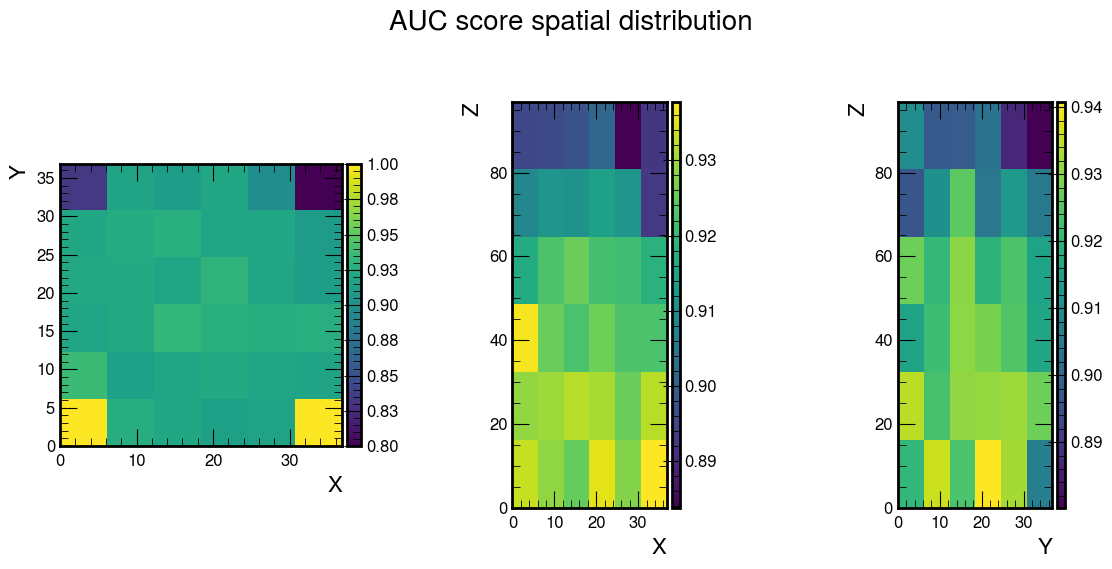

In [16]:
plt.rc('axes',  titlesize=12)
plt.rc('axes',  labelsize=16)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12, 6))
im1 = ax0.imshow(xy,extent=(0,max(X),0,max(Y)))#,vmin=0.94,vmax=0.965)
ax0.set(xlabel='X',ylabel='Y')
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax,format='%.2f')
im2 = ax1.imshow(xz,extent=(0,max(X),0,max(Z)))#,vmin=0.94,vmax=0.965)
ax1.set(xlabel='X',ylabel='Z')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax,format='%.2f')
im3 = ax2.imshow(yz,extent=(0,max(Y),0,max(Z)))#,vmin=0.94,vmax=0.965)
ax2.set(xlabel='Y',ylabel='Z')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax,format='%.2f')
fig.suptitle('AUC score spatial distribution',fontsize=20)
fig.tight_layout()
plt.savefig(f'IN_{dataset_name}/AUC_dist.png',bbox_inches='tight')

In [17]:
Xsig = []
Ysig = []
Zsig = []
Xbkg = []
Ybkg = []
Zbkg = []
t = tqdm(range(0, len(test_dataset)))
for i in t:
    if test_dataset[i].y==0:
        Xbkg.append(np.mean(test_dataset[i].u.numpy().transpose()[0]))
        Ybkg.append(np.mean(test_dataset[i].u.numpy().transpose()[1]))
        Zbkg.append(np.mean(test_dataset[i].u.numpy().transpose()[2]))
    else:
        Xsig.append(np.mean(test_dataset[i].u.numpy().transpose()[0]))
        Ysig.append(np.mean(test_dataset[i].u.numpy().transpose()[1]))
        Zsig.append(np.mean(test_dataset[i].u.numpy().transpose()[2]))

  0%|          | 0/101100 [00:00<?, ?it/s]

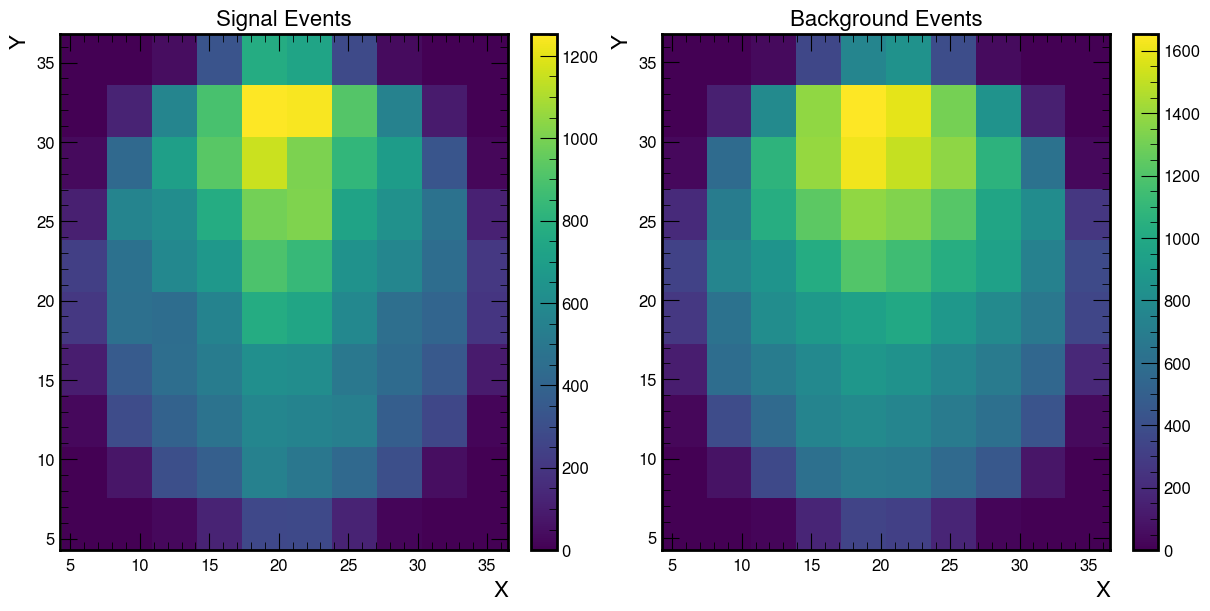

In [18]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.rc('axes',  titlesize=16)
plt.rc('axes',  labelsize=16)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12, 6))
im1 = ax0.hist2d(Xsig,Ysig)
ax0.set(xlabel='X',ylabel='Y',title='Signal Events')
fig.colorbar(im1[3],ax=ax0)
im2 = ax1.hist2d(Xbkg,Ybkg)
ax1.set(xlabel='X',ylabel='Y',title='Background Events')
fig.colorbar(im2[3],ax=ax1)
plt.savefig(f'IN_{dataset_name}/EventDist.png',bbox_inches='tight')

In [19]:
# create energy histograms
#if dataset_name=='DataMCmix' or dataset_name=='DataMCmix_SB50':
#    Data   = pd.read_hdf('./Input_Dataframes/cdst_voxel_Data_calib.h5')
#    MC     = pd.read_hdf('./Input_Dataframes/cdst_voxel_RecoBig.h5')
#    Data   = Data[Data.dataset_id<Data.dataset_id.unique()[-1]]
#    if dataset_name=='DataMCmix_SB50':
#        MC = MC[MC.dataset_id<=MC.dataset_id.unique()[len(Data.dataset_id.unique())+100]]
#    Dindex = np.where(dataset.y==1)[0]
#    Mindex = np.where(dataset.y==0)[0]
#    Dict_D = dict(zip(Data.dataset_id.unique(), Dindex))
#    Dict_M = dict(zip(MC.dataset_id.unique(), Mindex))
#    
#    Data.binclass = 1
#    MC.binclass   = 0
#    Data['dataset_id'] = Data['dataset_id'].replace(Dict_D)
#    eventInfo = MC[['dataset_id']].drop_duplicates().reset_index(drop=True)
#    eventInfo['new_dataset_id'] = eventInfo['dataset_id'].replace(Dict_M)
#    
#    MC     = pd.merge(eventInfo,MC,on='dataset_id',how='right')
#    MC     = MC.drop('dataset_id',axis=1)
#    MC     = MC.rename(columns={'new_dataset_id':'dataset_id'})
#    source = pd.concat([Data,MC])
#    source = source.sort_values(by='dataset_id').reset_index(drop=True)
#else:
source = pd.read_hdf(DS.raw_file_names.fget(DS)[0])
    
source_test = source[source.dataset_id>=source.dataset_id.unique()[int(2/3*len(source.dataset_id.unique()))]]
E           = np.array(source_test.groupby(['dataset_id'])['energy'].sum())

In [20]:
#Verification of the energy histogram using 100 random samples

R = random.sample(range(0,len(test_dataset)),100)
for i in tqdm(R):
    if (torch.tensor(DS.construct_center(DS,source_test[source_test.dataset_id==source_test.dataset_id.unique()[i]]))!=test_dataset[i].u).any():
        print(i)
        raise ValueError(f'Source and graph dataset indices are not matching up at index {i}!')

  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
NBins = 20
EBins = np.linspace(min(E),max(E),NBins+1)
E_sorted, keys_e = zip(*sorted(zip(E,range(0,len(y_test)))))
ERS   = []
ERB   = []
ERSe  = []
ERBe  = []

for i in tqdm(range(0,NBins)):
    keys_ei = keys_e[len([x for x in E if x<=EBins[i]]):len([x for x in E if x<=EBins[i+1]])]
    a       = np.array([y_test[x]    for x in keys_ei])
    b       = np.array([y_predict[x] for x in keys_ei])
    PredS   = np.array([a[i] for i in range(0,len(a)) if b[i]>=xmax])
    PredB   = np.array([a[i] for i in range(0,len(a)) if b[i]<xmax])
    Seff    = len(PredS[PredS==1])/len(a[a==1])
    Beff    = len(PredB[PredB==0])/len(a[a==0])
    ERS.append(Seff)
    ERB.append(Beff)
    ERSe.append(Seff*np.sqrt(1/len(PredS[PredS==1])+1/len(a[a==1])))
    ERBe.append(Beff*np.sqrt(1/len(PredB[PredB==0])+1/len(a[a==0])))

  0%|          | 0/20 [00:00<?, ?it/s]

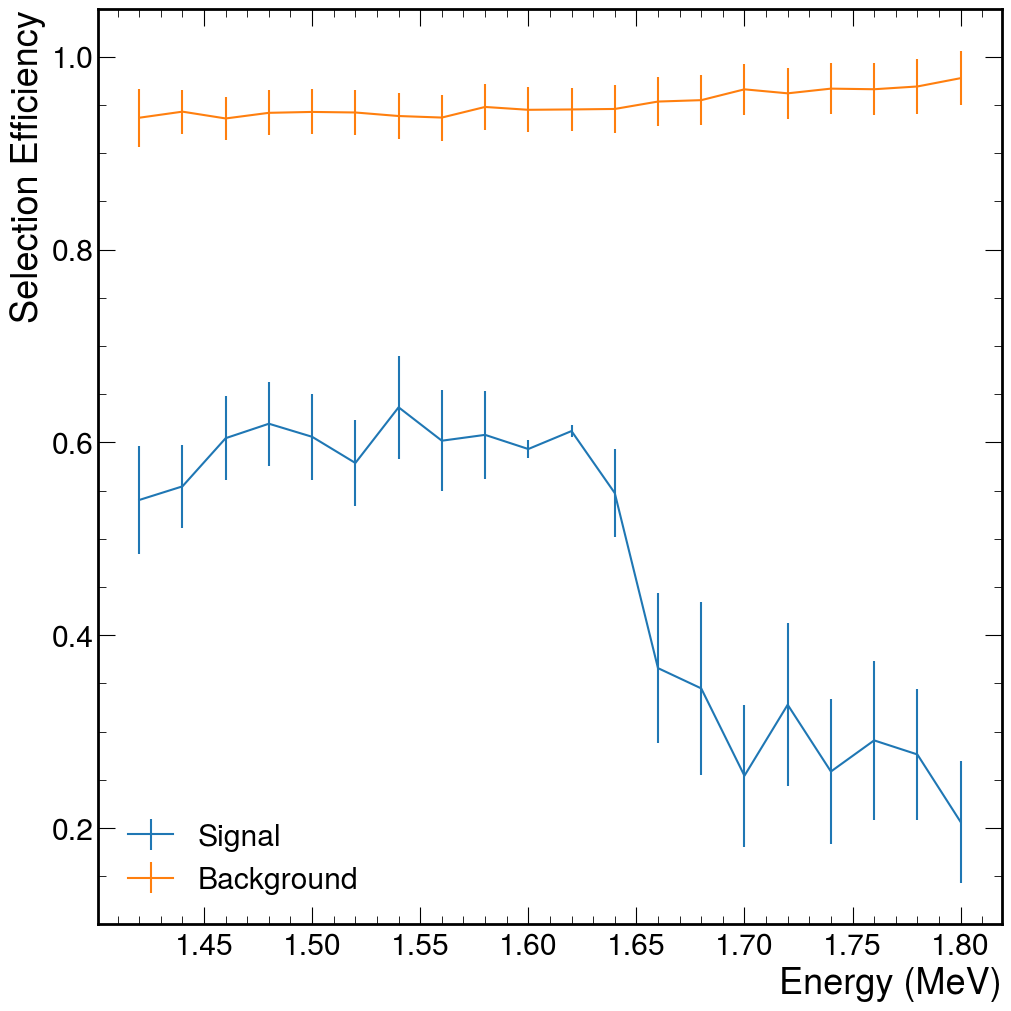

In [22]:
plt.style.use(hep.style.ROOT)

plt.errorbar(EBins[1:],ERS,ERSe,label='Signal')
plt.errorbar(EBins[1:],ERB,ERBe,label='Background')
plt.ylabel('Selection Efficiency')
plt.xlabel('Energy (MeV)')
plt.legend()
plt.savefig(f'IN_{dataset_name}/Efficiency.png',bbox_inches='tight')

In [23]:
S           = []
B           = []
for i in tqdm(range(0,len(E))):
    if y_predict[i]<xmax:
        B.append(E[i])
    else:
        S.append(E[i])

  0%|          | 0/101100 [00:00<?, ?it/s]

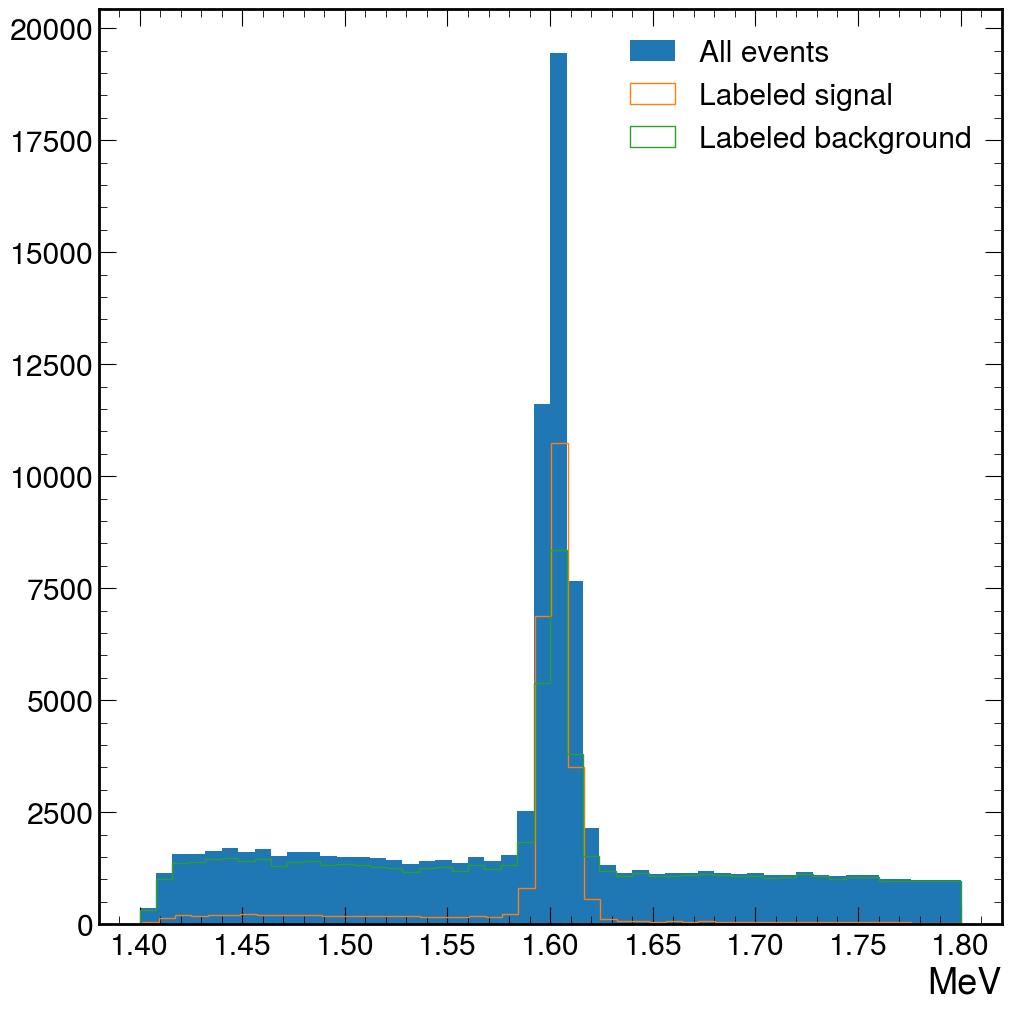

In [24]:
plt.hist(E,50,label='All events')
plt.hist(S,50,histtype='step',label='Labeled signal')
plt.hist(B,50,histtype='step',label='Labeled background');
plt.xlabel('MeV')
plt.legend()

/tmp/fkellere/ipykernel_131898/1387311871.py:22: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


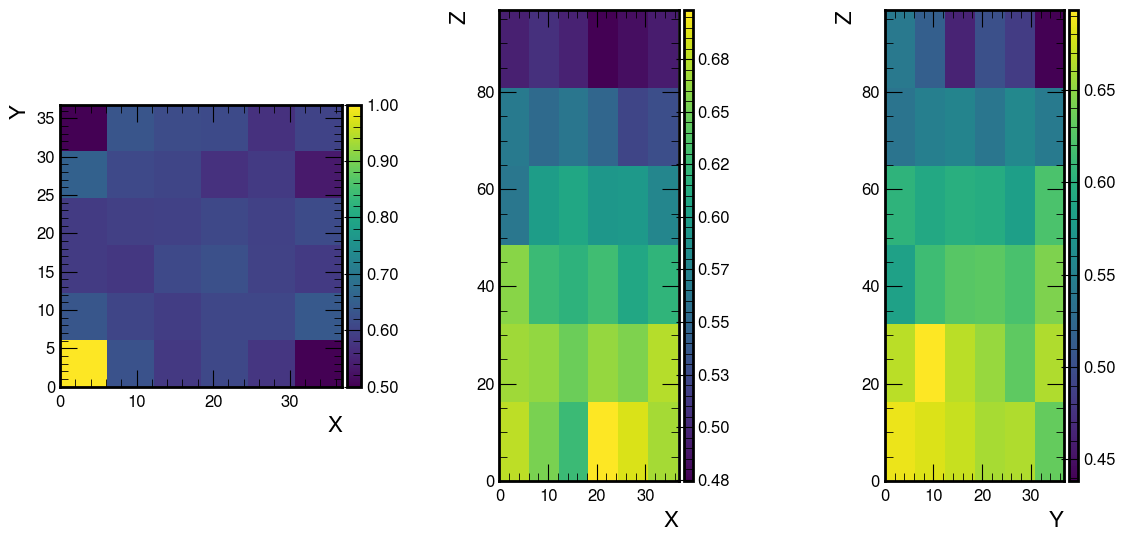

In [25]:
plt.rc('axes',  titlesize=12)
plt.rc('axes',  labelsize=16)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12, 6))
im1 = ax0.imshow(xyrs,extent=(0,max(X),0,max(Y)))#,vmin=0.94,vmax=0.965)
ax0.set(xlabel='X',ylabel='Y')
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax,format='%.2f')
im2 = ax1.imshow(xzrs,extent=(0,max(X),0,max(Z)))#,vmin=0.94,vmax=0.965)
ax1.set(xlabel='X',ylabel='Z')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax,format='%.2f')
im3 = ax2.imshow(yzrs,extent=(0,max(Y),0,max(Z)))#,vmin=0.94,vmax=0.965)
ax2.set(xlabel='Y',ylabel='Z')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax,format='%.2f')
fig.tight_layout()
plt.savefig(f'IN_{dataset_name}/Ratio_signal_dist.png',bbox_inches='tight')

/tmp/fkellere/ipykernel_131898/2442877245.py:22: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


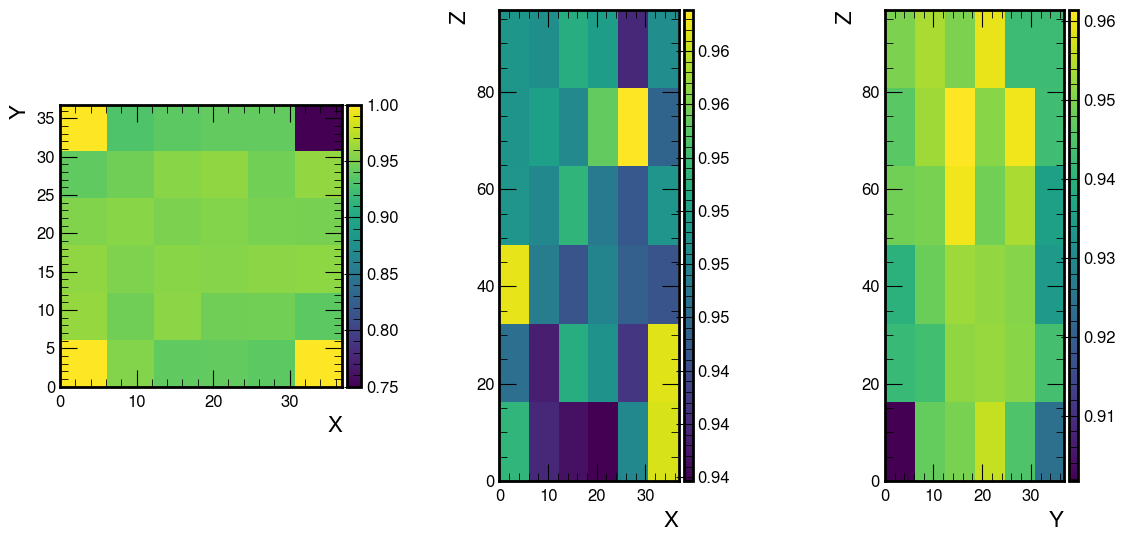

In [26]:
plt.rc('axes',  titlesize=12)
plt.rc('axes',  labelsize=16)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12, 6))
im1 = ax0.imshow(xyrb,extent=(0,max(X),0,max(Y)))#,vmin=0.94,vmax=0.965)
ax0.set(xlabel='X',ylabel='Y')
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax,format='%.2f')
im2 = ax1.imshow(xzrb,extent=(0,max(X),0,max(Z)))#,vmin=0.94,vmax=0.965)
ax1.set(xlabel='X',ylabel='Z')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax,format='%.2f')
im3 = ax2.imshow(yzrb,extent=(0,max(Y),0,max(Z)))#,vmin=0.94,vmax=0.965)
ax2.set(xlabel='Y',ylabel='Z')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax,format='%.2f')
fig.tight_layout()
plt.savefig(f'IN_{dataset_name}/Ratio_background_dist.png',bbox_inches='tight')

In [27]:
Seff_te[np.argmax(fom)]

0.600426832225833

In [28]:
Brej_te[np.argmax(fom)]

0.9498379714696155

In [29]:
max(fom)

2.6808501959298328

In [30]:
thre_IN = thre_te
Figm_IN = Figm_te
Seff_IN = Seff_te
Brej_IN = Brej_te
%store thre_IN
%store Figm_IN
%store Seff_IN
%store Brej_IN

Stored 'thre_IN' (ndarray)
Stored 'Figm_IN' (list)
Stored 'Seff_IN' (list)
Stored 'Brej_IN' (list)
